Machine Learning aplicado a la predicción de precio de criptomonedas, utilizando valores anteriores de las principales critpomonedas, valores de índices de stocks, y trends de búsqueda. 

In [3]:
# Manipulación de datos
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt # Plots

# Keras
from math import sqrt
from sklearn.metrics import mean_squared_error

In [4]:
criptomonedas_posibles = ['bitcoin','ethereum','ripple','dash','litecoin',
                     'monero','ethereum-classic','nem','augur',                 
                     'litecoin','cardano','stellar','iota','tron',
                     'neo','dash','bitcoin-cash','eos','vechain',
                     'tether','qtum','omisego','icon','binance-coin',
                     'lisk','bitcoin-gold','bytecoin-bcn','nano','verge',
                     'zcash','aeternity','zilliqa']
top_criptomonedas = ['bitcoin','ethereum','ripple','dash','litecoin','monero','ethereum-classic','nem','augur']
stocks_names=['AAPL','FB','GOOG','GOOGL','IBM','INTC','MSFT','NFLX','ORCL','TSLA']
stockindex_names=['^IXIC','^RUT','^DJI','^GSPC']

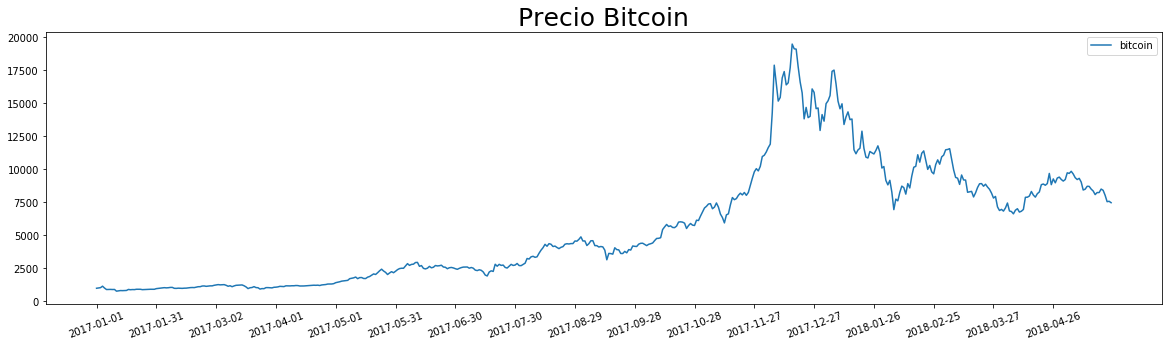

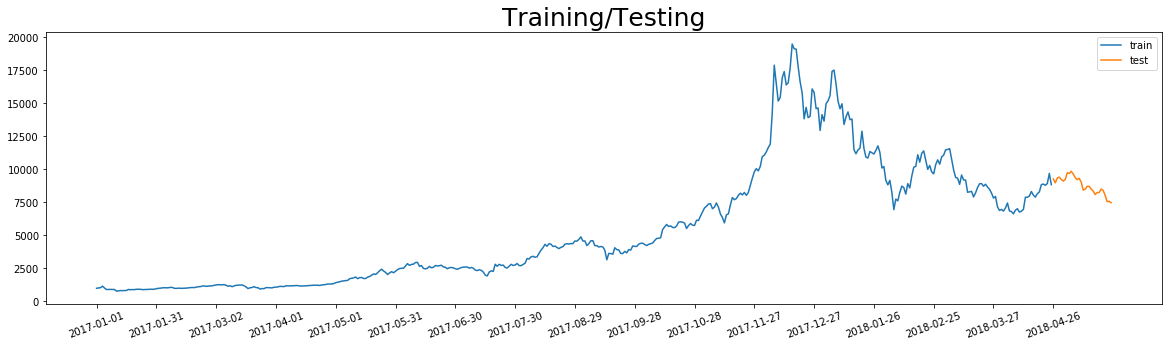

In [16]:
df = pd.read_csv('data/data.csv', usecols=['Date','bitcoin'])
df.set_index('Date',inplace=True)


plt.figure(figsize=(20,5))
plt.title("Precio Bitcoin", fontsize=25)
major_ticks = np.arange(0, len(df), 30)
plt.xticks(major_ticks, np.array(df.index[::30]), rotation=20)
plt.plot(df, label="bitcoin")
plt.legend()
plt.show()

test_size=30
window_size=1
dia_futuro=1

train = df[0:len(df)-test_size]
test  = df[len(df)-test_size:]
plt.figure(figsize=(20,5))
plt.title("Training/Testing", fontsize=25)
major_ticks = np.arange(0, len(df), 30)
plt.xticks(major_ticks, np.array(df.index[::30]), rotation=20)
plt.plot(train, label="train")
plt.plot(test, label="test")
plt.legend()
plt.show()

Método "naive": el precio del día siguiente es igual al anterior.

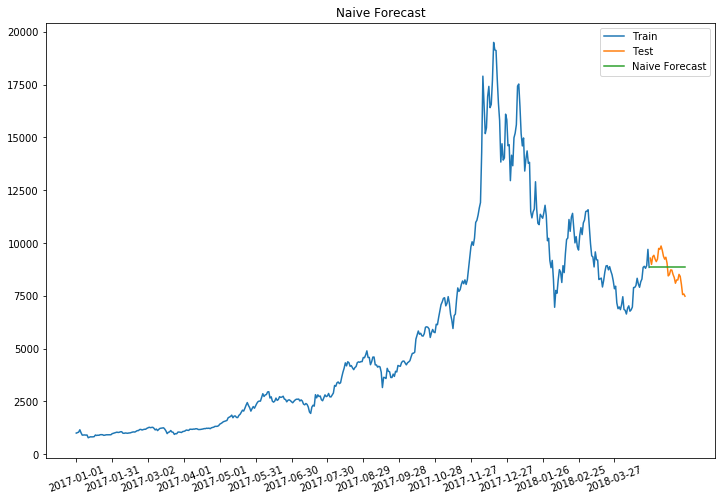

RMSE:659.8916969649894


In [30]:
precios = np.asarray(train.bitcoin)
y_naive = test.copy()
y_naive['naive'] = precios[len(precios)-1]
plt.figure(figsize=(12,8))
plt.xticks(major_ticks, np.array(df.index[::30]), rotation=20)
plt.plot(train.index, train['bitcoin'], label='Train')
plt.plot(test.index, test['bitcoin'], label='Test')
plt.plot(y_naive.index, y_naive['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

rms = sqrt(mean_squared_error(test.bitcoin, y_naive.naive))
print("RMSE:" + str(rms))